Décomposition saisonnière

[*********************100%***********************]  1 of 1 completed


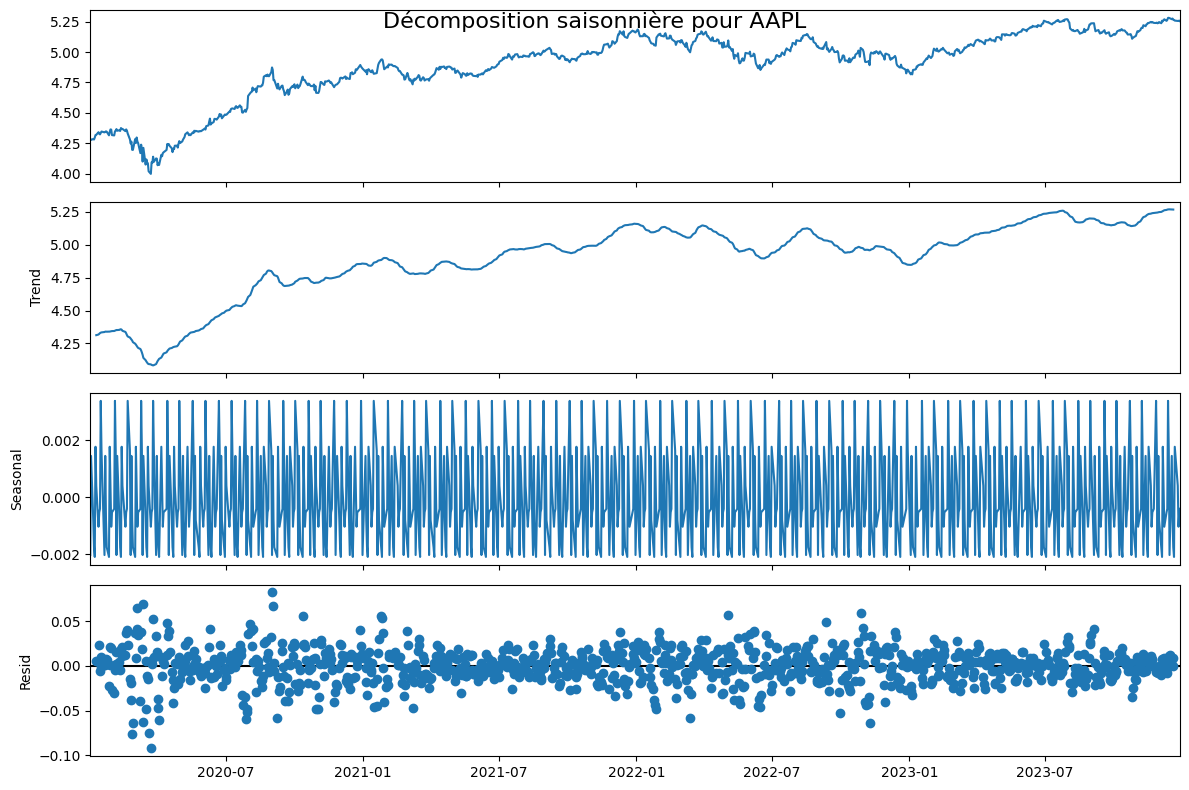

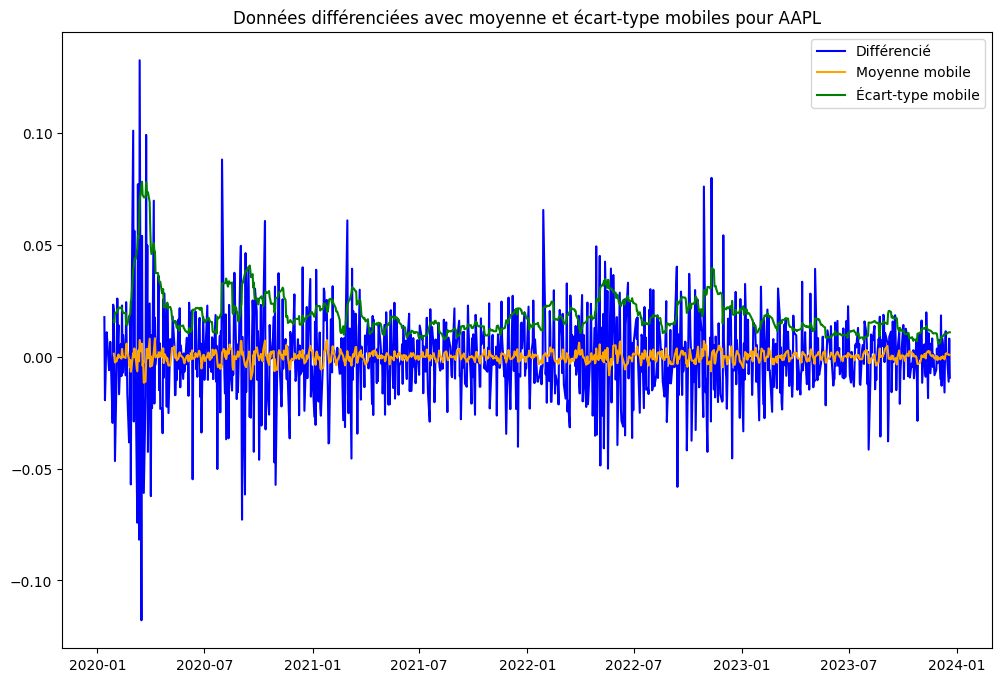

Résultats du test ADF pour AAPL :
Statistique ADF : -10.186
p-valeur : 0.00000

Valeurs critiques :
Valeur critique (1%) : -3.437
Valeur critique (5%) : -2.865
Valeur critique (10%) : -2.568

Les résidus sont stationnaires (p-valeur <= 0.05).


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import yfinance as yf

# Télécharger des données réelles avec yfinance
symbol = "AAPL"  # Exemple : Apple Inc.
start_date = "2020-01-01"
end_date = "2023-12-31"

# Récupération des données
data = yf.download(symbol, start=start_date, end=end_date)

# Utilisation des prix de clôture ajustés
df = data[['Close']].rename(columns={'Close': 'value'})

# Transformation logarithmique pour stabiliser la variance
df_log = np.log(df['value'])

# Décomposition saisonnière
decompose_result = seasonal_decompose(df_log.dropna(), period=12)  # 'period' pour définir la saisonnalité mensuelle
df_trend = decompose_result.trend
df_season = decompose_result.seasonal
df_residual = decompose_result.resid

# Visualisation des composantes
plt.rcParams['figure.figsize'] = (12, 8)
decompose_result.plot()
plt.suptitle(f"Décomposition saisonnière pour {symbol}", fontsize=16)
plt.show()

# Analyse des résidus
# Différencier les résidus pour rendre les données stationnaires
df_log_diff = df_residual.diff().dropna()

# Calcul de la moyenne mobile et de l'écart-type mobile
rolling_window = 12
df_diff_rolling = df_log_diff.rolling(rolling_window)
df_diff_ma = df_diff_rolling.mean()
df_diff_std = df_diff_rolling.std()

# Visualisation des données différenciées avec moyenne et écart-type
plt.figure(figsize=(12, 8))
plt.plot(df_log_diff, label='Différencié', color='blue')
plt.plot(df_diff_ma, label='Moyenne mobile', color='orange')
plt.plot(df_diff_std, label='Écart-type mobile', color='green')
plt.legend()
plt.title(f"Données différenciées avec moyenne et écart-type mobiles pour {symbol}")
plt.show()

# Test de stationnarité avec ADF
adf_result = adfuller(df_residual.dropna())
print(f"Résultats du test ADF pour {symbol} :")
print(f"Statistique ADF : {adf_result[0]:.3f}")
print(f"p-valeur : {adf_result[1]:.5f}")

print("\nValeurs critiques :")
for key, value in adf_result[4].items():
    print(f"Valeur critique ({key}) : {value:.3f}")

# Interprétation du test ADF
if adf_result[1] <= 0.05:
    print("\nLes résidus sont stationnaires (p-valeur <= 0.05).")
else:
    print("\nLes résidus ne sont pas stationnaires (p-valeur > 0.05).")


# Finding model parameters by grid search
A grid search, also known as the hyperparameter optimization method, can be used toiteratively explore different combinations of parameters for fitting our ARIMA model. Wecan fit a seasonal ARIMA model with the SARIMAX() function of the statsmodels modulein each iteration, returning an object of the MLEResults class. The MLEResults objectholds an aic attribute for returning the AIC value. The model with the lowest AIC valuegives us the best-fitting model that determines our parameters of p, d, and q. Moreinformation on SARIMAX can be found at https:/󰜌/󰜌www.󰜌statsmodels.󰜌org/󰜌dev/󰜌generated/statsmodels.󰜌tsa.󰜌statespace.󰜌sarimax.󰜌SARIMAX.󰜌html.

In the SARIMAX (seasonal autoregressive integrated movingaverage with exogenous regressors model) function, we provided the seasonal_orderparameter, which is the ARIMA(p,d,q,s) seasonal component, where s is the number ofperiods in a season of the dataset. 

In [10]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Désactiver les avertissements pour simplifier la sortie
warnings.filterwarnings("ignore")

def arima_grid_search(dataframe, seasonal_period):
    """
    Effectue une recherche exhaustive pour déterminer les meilleurs paramètres (p, d, q)
    et leur équivalent saisonnier pour un modèle SARIMA en utilisant le critère AIC.

    Args:
        dataframe (pd.Series): Série temporelle utilisée pour ajuster le modèle.
        seasonal_period (int): Période saisonnière (par exemple, 12 pour des données mensuelles).

    Returns:
        tuple: Meilleur AIC, paramètres (p, d, q), et paramètres saisonniers (P, D, Q, s).
    """
    # Définir les plages de paramètres
    p = d = q = range(0, 2)  # On limite les valeurs pour éviter un temps de calcul trop long
    param_combinations = list(itertools.product(p, d, q))
    
    lowest_aic = float("inf")
    best_order = None
    best_seasonal_order = None

    # Boucle sur toutes les combinaisons de paramètres
    for order in param_combinations:
        for seasonal_order in itertools.product(p, d, q, [seasonal_period]):
            try:
                # Ajuster le modèle SARIMA
                model = SARIMAX(
                    dataframe,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                model_result = model.fit(disp=False)

                # Vérifier si cet AIC est le plus bas
                if model_result.aic < lowest_aic:
                    lowest_aic = model_result.aic
                    best_order = order
                    best_seasonal_order = seasonal_order

            except Exception as e:
                # Ignorer les combinaisons problématiques
                continue

    return lowest_aic, best_order, best_seasonal_order

# Exemple d'utilisation avec des données réelles
import yfinance as yf

# Télécharger les données (ici, Apple)
symbol = "AAPL"
start_date = "2020-01-01"
end_date = "2020-12-31"
data = yf.download(symbol, start=start_date, end=end_date)

# Utiliser les prix de clôture ajustés
df_settle = data['Close'].dropna()


# Effectuer la recherche de grille avec une période saisonnière de 12 (données mensuelles)
lowest_aic, order, seasonal_order = arima_grid_search(df_settle, seasonal_period=12)

# Résultats
print(f"Meilleur modèle SARIMA : ARIMA{order}x{seasonal_order}")
print(f"Critère AIC le plus bas : {lowest_aic:.3f}")

# Si le temps d'execusion est trop long, on peut travailler sur un sous-échantillon : 
# Exemple : résumer en données hebdomadaires
# df_settle_sample = df_settle.resample('W').mean() 


[*********************100%***********************]  1 of 1 completed


Meilleur modèle SARIMA : ARIMA(0, 1, 1)x(0, 1, 1, 12)
Critère AIC le plus bas : 1096.610


In [11]:
from pmdarima import auto_arima

model = auto_arima(df_settle, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1182.979, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1178.792, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1179.524, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1183.051, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1176.804, Time=0.04 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1178.786, Time=0.20 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1177.869, Time=0.59 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1178.478, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1178.508, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1177.535, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1180.478, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=1177.780, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[12] intercept
Total fit time: 3.789 seconds
             

# Fitting the SARIMAX model

[*********************100%***********************]  1 of 1 completed


                                     SARIMAX Results                                      
Dep. Variable:                               AAPL   No. Observations:                  252
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -545.305
Date:                            Thu, 27 Feb 2025   AIC                           1096.610
Time:                                    20:00:37   BIC                           1106.858
Sample:                                         0   HQIC                          1100.746
                                            - 252                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1514      0.064     -2.348      0.019      -0.278      -0.025
ma.S.L12      -1.0000    398.718   

count    252.000000
mean       0.221334
std        6.118767
min      -49.000338
25%       -1.161901
50%        0.121462
75%        1.643965
max       72.716072
dtype: float64

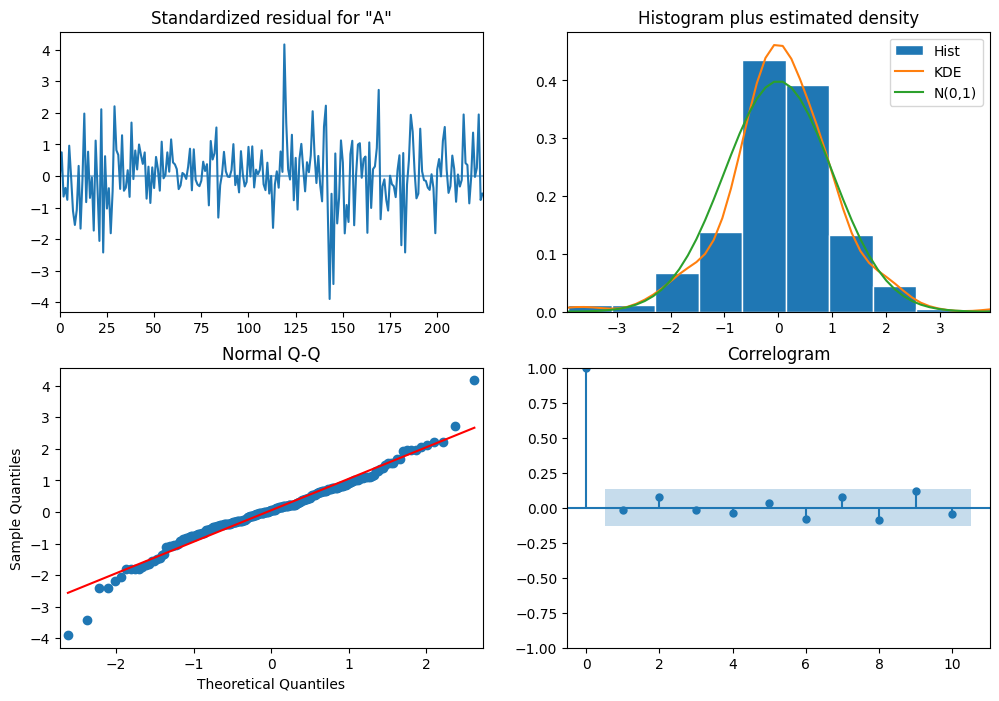

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    df_settle,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
    disp=False
)

# Télécharger les données (ici, Apple)
symbol = "AAPL"
start_date = "2020-01-01"
end_date = "2020-12-31"
data = yf.download(symbol, start=start_date, end=end_date)

# Utiliser les prix de clôture ajustés
df_settle = data['Close'].dropna()

model_results = model.fit(maxiter=200, disp=False)
print(model_results.summary())

model_results.plot_diagnostics(figsize=(12, 8))

model_results.resid.describe()